In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf

from model.tf.hydro import ProductionStorage
from model.tf.ml import ConvNet, LSTM
from data.tf.camels_dataset import CamelsDataset, HybridDataset

2024-08-30 09:01:54.288563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
window_size = 10
camels_dir = '../data/camels/aus'

In [3]:
camels_ds = CamelsDataset(data_dir=camels_dir, 
                          station_list=['422321B'],
                          # state_outlet='WA', map_zone=50
                          target_vars=['flow_cdf'],
                          window_size=window_size)
train_ds, test_ds = camels_ds.get_datasets(batch_size=256)

In [4]:
ts_input_dim = 4
hidden_dim = 32
lstm_dim = 64
n_layers = 2
ts_output_dim = 32
dropout = 0.1

static_input_dim = 7
static_hidden_dim = 32
static_output_dim = 32

combined_hidden_dim = 32

In [11]:
def get_model():
    ts_model = LSTM(input_dim=ts_input_dim,
                hidden_dim=hidden_dim,
                lstm_dim=lstm_dim,
                n_layers=n_layers,
                output_dim=ts_output_dim,
                dropout=dropout)

    static_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(static_hidden_dim, activation='relu'),
                        tf.keras.layers.Dense(static_hidden_dim, activation='relu'),
                        tf.keras.layers.Dense(static_output_dim, activation='linear')
                    ])

    timeseries = tf.keras.Input(shape=(window_size, ts_input_dim), name='timeseries')
    static = tf.keras.Input(shape=(static_input_dim,), name='static')

    concatenated = tf.keras.layers.Concatenate()([ts_model(timeseries), static_model(static)])
    hidden = tf.keras.layers.Dense(combined_hidden_dim, activation='relu')(concatenated)
    hidden = tf.keras.layers.Dense(combined_hidden_dim, activation='relu')(concatenated)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

    model_combined = tf.keras.Model(inputs=[timeseries, static], outputs=output)
    return model_combined

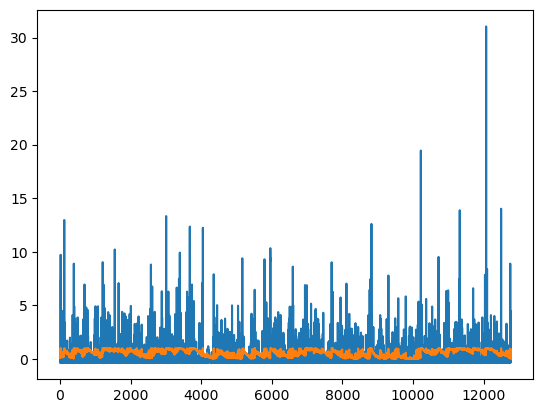

In [12]:
import matplotlib.pyplot as plt
plt.plot(camels_ds.ts_arr[:, -1, 0])
plt.plot(camels_ds.target_arr[:, -1])

In [13]:
camels_ds.ts_data[camels_ds.ts_vars].mean(), camels_ds.ts_data[camels_ds.ts_vars].std()

(precipitation_AWAP      -6.564203e-09
 et_morton_actual_SILO    1.193492e-08
 tmax_awap               -9.547932e-09
 tmin_awap               -1.357543e-08
 dtype: float32,
 precipitation_AWAP       1.000039
 et_morton_actual_SILO    1.000039
 tmax_awap                1.000038
 tmin_awap                1.000039
 dtype: float32)

In [14]:
camels_ds.targets[camels_ds.target_vars].mean(), camels_ds.targets[camels_ds.target_vars].std()

(flow_cdf    0.5
 dtype: float64,
 flow_cdf    0.288664
 dtype: float64)

In [15]:

epochs = 50

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4, beta_1=0.89, beta_2=0.999, weight_decay=2e-3)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

model = get_model()


for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    epoch_loss = 0.0

    # Iterate over the batches of the dataset.
    for step, batch in enumerate(train_ds):
        
        with tf.GradientTape() as tape:
            
            # Run the forward pass of the layer.
            out = model([batch['timeseries'], batch['static']], training=True) 

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(batch['target'], out)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        epoch_loss += loss_value
    
    epoch_loss = epoch_loss/len(train_ds)
    
    val_loss = 0.

    for step, batch in enumerate(test_ds):
            
        # Run the forward pass of the layer.
        out = model([batch['timeseries'], batch['static']], training=False) 

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(batch['target'], out)

        val_loss += loss_value

    val_loss = val_loss/len(test_ds)
    
    print(f"Epoch {epoch + 1} loss: {epoch_loss.numpy():.4f}, val_loss: {val_loss.numpy():.4f}")


Start of epoch 0


2024-08-30 09:03:46.070455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:03:46.559774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 loss: 0.0659, val_loss: 0.0870

Start of epoch 1


2024-08-30 09:03:52.505886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:03:53.049387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 loss: 0.0537, val_loss: 0.0941

Start of epoch 2


2024-08-30 09:03:58.898840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:03:59.343210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 loss: 0.0521, val_loss: 0.0865

Start of epoch 3


2024-08-30 09:04:04.650268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:05.104545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 loss: 0.0517, val_loss: 0.0832

Start of epoch 4


2024-08-30 09:04:10.499381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:10.960540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 loss: 0.0511, val_loss: 0.0797

Start of epoch 5


2024-08-30 09:04:16.403336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:16.863264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 loss: 0.0510, val_loss: 0.0804

Start of epoch 6


2024-08-30 09:04:22.337983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:22.895846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 loss: 0.0508, val_loss: 0.0822

Start of epoch 7


2024-08-30 09:04:28.812463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:29.376493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 loss: 0.0506, val_loss: 0.0860

Start of epoch 8


2024-08-30 09:04:34.952602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:35.414785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 loss: 0.0504, val_loss: 0.0801

Start of epoch 9


2024-08-30 09:04:40.858652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:41.300291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10 loss: 0.0504, val_loss: 0.0861

Start of epoch 10


2024-08-30 09:04:46.683945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:47.141048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11 loss: 0.0501, val_loss: 0.0849

Start of epoch 11


2024-08-30 09:04:52.803620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:53.337654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12 loss: 0.0502, val_loss: 0.0820

Start of epoch 12


2024-08-30 09:04:59.278461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:04:59.983384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13 loss: 0.0502, val_loss: 0.0755

Start of epoch 13


2024-08-30 09:05:06.975906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:07.461621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14 loss: 0.0497, val_loss: 0.0813

Start of epoch 14


2024-08-30 09:05:13.746087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:14.218837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 loss: 0.0495, val_loss: 0.0775

Start of epoch 15


2024-08-30 09:05:19.913324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:20.364177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 loss: 0.0496, val_loss: 0.0870

Start of epoch 16


2024-08-30 09:05:25.788903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:26.199650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17 loss: 0.0492, val_loss: 0.0873

Start of epoch 17


2024-08-30 09:05:31.494886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:31.922860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18 loss: 0.0493, val_loss: 0.0828

Start of epoch 18


2024-08-30 09:05:37.196140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:37.622360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19 loss: 0.0488, val_loss: 0.0809

Start of epoch 19


2024-08-30 09:05:42.876975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:43.297558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20 loss: 0.0488, val_loss: 0.0788

Start of epoch 20


2024-08-30 09:05:48.589189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:49.026771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21 loss: 0.0489, val_loss: 0.0846

Start of epoch 21


2024-08-30 09:05:54.255610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:05:54.666661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22 loss: 0.0482, val_loss: 0.0839

Start of epoch 22


2024-08-30 09:05:59.872806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:00.299481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23 loss: 0.0480, val_loss: 0.0876

Start of epoch 23


2024-08-30 09:06:06.613496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:07.122493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24 loss: 0.0482, val_loss: 0.0897

Start of epoch 24


2024-08-30 09:06:13.684866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:14.231014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25 loss: 0.0478, val_loss: 0.0876

Start of epoch 25


2024-08-30 09:06:20.081497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:20.524101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26 loss: 0.0477, val_loss: 0.0767

Start of epoch 26


2024-08-30 09:06:26.081042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:26.513846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27 loss: 0.0475, val_loss: 0.0782

Start of epoch 27


2024-08-30 09:06:31.760320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:32.213489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28 loss: 0.0481, val_loss: 0.0808

Start of epoch 28


2024-08-30 09:06:37.454768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:37.915257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29 loss: 0.0475, val_loss: 0.0846

Start of epoch 29


2024-08-30 09:06:43.720169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:44.206607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30 loss: 0.0472, val_loss: 0.0802

Start of epoch 30


2024-08-30 09:06:49.966913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:50.462110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31 loss: 0.0470, val_loss: 0.0805

Start of epoch 31


2024-08-30 09:06:57.715316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:06:58.307038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32 loss: 0.0467, val_loss: 0.0826

Start of epoch 32


2024-08-30 09:07:05.689432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:06.217805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33 loss: 0.0464, val_loss: 0.0822

Start of epoch 33


2024-08-30 09:07:12.361886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:12.758280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34 loss: 0.0464, val_loss: 0.0808

Start of epoch 34


2024-08-30 09:07:17.339218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:17.714053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35 loss: 0.0462, val_loss: 0.0913

Start of epoch 35


2024-08-30 09:07:22.316196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:22.709180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36 loss: 0.0459, val_loss: 0.0831

Start of epoch 36


2024-08-30 09:07:27.300275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:27.670025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37 loss: 0.0461, val_loss: 0.0880

Start of epoch 37


2024-08-30 09:07:32.466675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:32.926690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38 loss: 0.0457, val_loss: 0.0808

Start of epoch 38


2024-08-30 09:07:37.737046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:38.080670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39 loss: 0.0457, val_loss: 0.0787

Start of epoch 39


2024-08-30 09:07:43.070410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:43.439005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40 loss: 0.0457, val_loss: 0.0860

Start of epoch 40


2024-08-30 09:07:48.073526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:48.426634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41 loss: 0.0451, val_loss: 0.0789

Start of epoch 41


2024-08-30 09:07:53.054093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:53.435852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42 loss: 0.0452, val_loss: 0.0839

Start of epoch 42


2024-08-30 09:07:58.340820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:07:58.985133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43 loss: 0.0452, val_loss: 0.0898

Start of epoch 43


2024-08-30 09:08:03.703567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:08:04.079748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44 loss: 0.0449, val_loss: 0.0813

Start of epoch 44


2024-08-30 09:08:08.676995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:08:09.049848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45 loss: 0.0446, val_loss: 0.0790

Start of epoch 45


2024-08-30 09:08:13.627063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:08:14.008989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46 loss: 0.0443, val_loss: 0.0867

Start of epoch 46


2024-08-30 09:08:18.561221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:08:19.026822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47 loss: 0.0441, val_loss: 0.0799

Start of epoch 47


2024-08-30 09:08:23.635601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:08:24.011442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48 loss: 0.0439, val_loss: 0.0852

Start of epoch 48


2024-08-30 09:08:28.572253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-30 09:08:28.940293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49 loss: 0.0442, val_loss: 0.0822

Start of epoch 49


2024-08-30 09:08:33.504943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50 loss: 0.0435, val_loss: 0.0788


2024-08-30 09:08:33.873536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
gr4j_logfile = 'results/gr4j/result.csv'
prod = ProductionStorage()
hybrid_ds = HybridDataset(data_dir=camels_dir, gr4j_logfile=gr4j_logfile, 
                          station_list=['314213'],
                          # state_outlet='WA', map_zone=50,
                          prod=prod, window_size=window_size)

In [ ]:
train_ds, test_ds = hybrid_ds.get_datasets(batch_size=256)

In [ ]:
for batch in train_ds:
    print(batch['station_id'].shape, batch['timeseries'].shape, batch['static'].shape, batch['target'].shape)
    break

(256, 1) (256, 7, 8) (256, 7) (256, 1)
